### BAF GAN ile Yapay Veri

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import time

C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('sample10.csv')  

categorical_columns = ["fraud_bool",'income', 'customer_age', 'payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'device_distinct_emails_8w', 'device_fraud_count', 'month']  

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

df = df.drop(columns=categorical_columns) 
df = pd.concat([df, encoded_df], axis=1)  

In [3]:
df.head()

,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,device_distinct_emails_8w_0,device_distinct_emails_8w_1,device_distinct_emails_8w_2,month_1,month_2,month_3,month_4,month_5,month_6,month_7
0,0.423184,-1,174,0.022402,3.354768,1140,3659.730906,6041.862379,6791.873595,278,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.246312,-1,60,0.009289,-0.305261,1118,4950.849565,4039.940368,4141.882552,14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.921065,29,148,0.009191,-1.054443,399,574.335478,2493.948454,3726.858015,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.547707,56,8,0.004642,-1.124991,4062,3484.847833,4210.512950,4288.197328,172,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.860882,-1,46,0.005121,-1.067835,1052,14073.211653,5469.019495,4997.056511,11,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
columns_to_scale = df.columns.difference(encoded_df.columns)  

scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [5]:
latent_dim = 100
num_epochs = 20
batch_size = 64

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(input_dim=latent_dim, output_dim=scaled_df.shape[1]).to(device)
discriminator = Discriminator(input_dim=scaled_df.shape[1]).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

data_tensor = torch.tensor(scaled_df.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def train_model():
    start_time = time.time()
    for epoch in range(num_epochs):
        for real_data in train_loader:
            real_data = real_data[0]

            batch_size = real_data.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_d.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')
    
    end_time = time.time()
    return end_time - start_time

if device.type == 'cuda':
    gpu_time = train_model()
    print(f"GPU eğitim süresi: {gpu_time:.2f} saniye")
else:
    cpu_time = train_model()
    print(f"CPU eğitim süresi: {cpu_time:.2f} saniye")


Epoch [1/20] | D Loss: 1.2464160323143005 | G Loss: 0.659417986869812
Epoch [2/20] | D Loss: 1.2246801257133484 | G Loss: 0.6254050135612488
Epoch [3/20] | D Loss: 1.1169805526733398 | G Loss: 0.8052630424499512
Epoch [4/20] | D Loss: 0.9477645456790924 | G Loss: 0.9935579299926758
Epoch [5/20] | D Loss: 0.9978712201118469 | G Loss: 0.8883084654808044
Epoch [6/20] | D Loss: 1.0023804306983948 | G Loss: 0.8850138187408447
Epoch [7/20] | D Loss: 1.083916574716568 | G Loss: 0.8285790681838989
Epoch [8/20] | D Loss: 1.0546537339687347 | G Loss: 0.8405890464782715
Epoch [9/20] | D Loss: 1.1280521750450134 | G Loss: 0.8660269975662231
Epoch [10/20] | D Loss: 0.9182719588279724 | G Loss: 0.9240119457244873
Epoch [11/20] | D Loss: 1.1044025421142578 | G Loss: 0.8603475093841553
Epoch [12/20] | D Loss: 1.087374210357666 | G Loss: 0.9789149761199951
Epoch [13/20] | D Loss: 0.9058161973953247 | G Loss: 0.9983322620391846
Epoch [14/20] | D Loss: 0.759530246257782 | G Loss: 1.1890273094177246
Epoc

In [6]:
num_samples = 1000000
noise = torch.randn(num_samples, latent_dim)

generated_data = generator(noise).detach().numpy()

generated_df = pd.DataFrame(generated_data, columns=scaled_df.columns)

generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])

categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_df.columns]))
categorical_output.columns = categorical_columns

generated_df = generated_df.drop(columns=encoded_df.columns)
generated_df = pd.concat([generated_df, categorical_output], axis=1)

In [7]:
generated_df

,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,...,income,customer_age,payment_type,employment_status,housing_status,source,device_os,device_distinct_emails_8w,device_fraud_count,month
0,0.761764,60.402851,17.271627,3.577464,27.496811,2353.493652,8502.250977,6093.371094,5590.875977,491.277863,...,0.7,30,AC,CE,BD,TELEAPP,windows,1,0,5
1,0.721753,60.374458,-0.065363,-1.470859,22.655479,2022.964355,4075.948730,4362.531250,5059.607910,498.675751,...,0.7,30,AB,CF,BC,TELEAPP,windows,1,0,5
2,0.774118,20.172577,164.660889,4.814564,27.786415,1234.815674,8629.577148,5262.697754,4236.445801,559.867615,...,0.7,30,AE,CE,BC,TELEAPP,x11,1,0,5
3,0.745612,44.888203,15.906454,2.690964,-3.912992,1272.647827,8678.618164,6246.917969,5764.328613,323.567474,...,0.7,90,AE,CC,BC,TELEAPP,windows,1,0,5
4,0.551427,57.688908,39.544514,-4.174934,26.557676,765.994690,2881.860840,3637.062988,5013.543945,617.963867,...,0.7,30,AE,CE,BC,TELEAPP,windows,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.640909,27.403238,165.107208,-1.094826,27.892561,966.327576,8499.982422,6174.873535,5316.948730,612.637817,...,0.7,90,AC,CE,BC,TELEAPP,windows,1,0,5
999996,0.315609,53.015896,14.339796,-1.429085,-11.143161,647.317322,5576.254883,5698.562500,5639.001465,558.881470,...,0.7,70,AC,CE,BB,TELEAPP,windows,1,0,5
999997,0.779660,55.757175,59.872005,-3.200737,21.851807,852.582825,8127.548340,4628.899414,4949.977051,-17.833994,...,0.5,30,AC,CC,BD,TELEAPP,windows,1,0,5
999998,0.589439,57.083260,1.312437,-3.227059,21.675779,2142.873535,8285.813477,6183.906738,5725.933105,600.775757,...,0.7,30,AB,CF,BC,TELEAPP,windows,1,0,5


In [15]:
generated_df['fraud_bool'].value_counts()

fraud_bool
1    1000000
Name: count, dtype: int64

In [9]:
#generated_df['fraud_bool'] =generated_df['fraud_bool'].apply(lambda x: 1 if x > 0.05 else 0)

In [10]:
#generated_df['fraud_bool'].value_counts()

In [11]:
df = pd.read_csv('sample10.csv')  

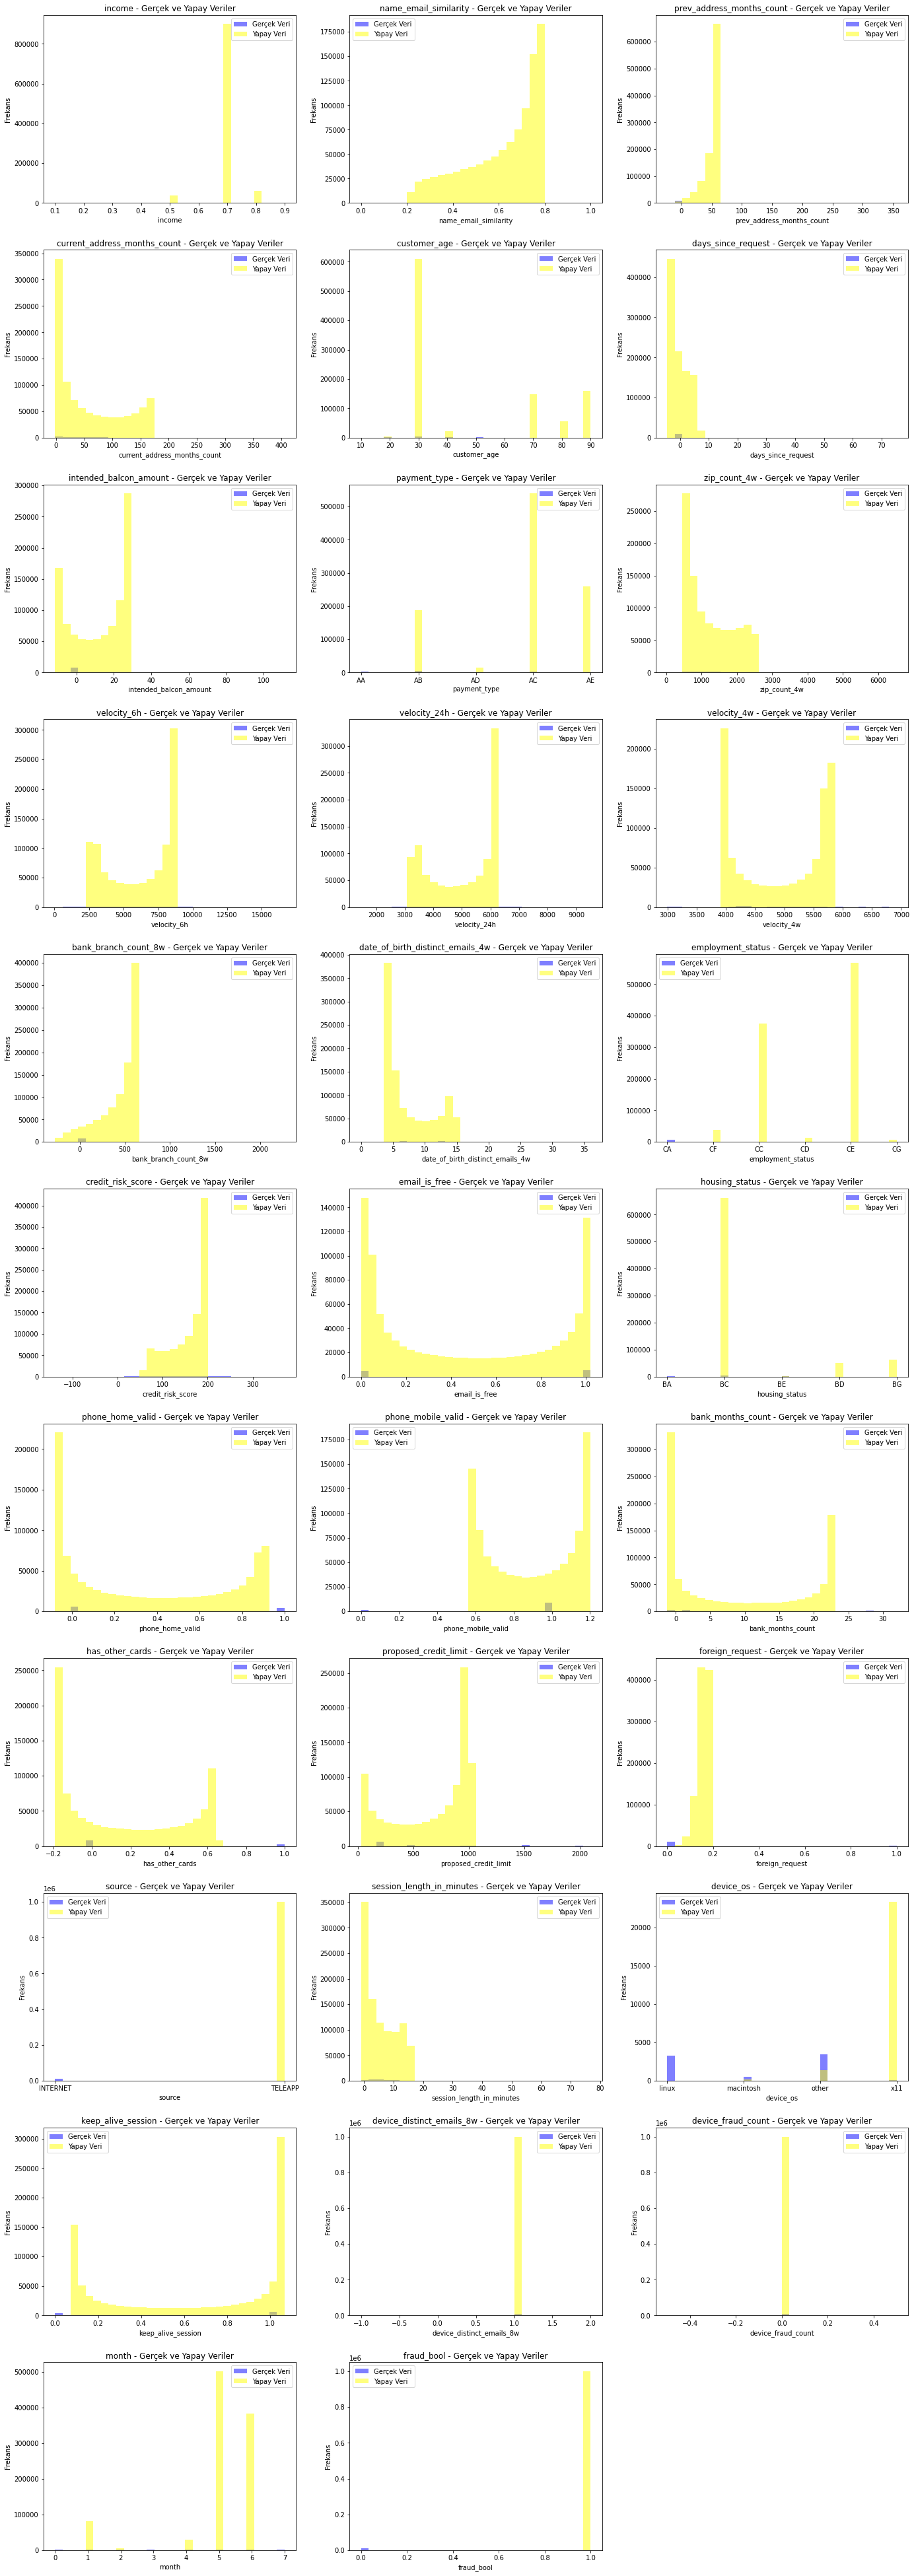

In [12]:
features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()